# CNNs Assignment: Face Recognition with LFW Dataset


* Introduction:
  * In this assignment, we will use the Labeled Faces in the Wild (LFW) dataset for face recognition.
  * The goal is to build a simple CNN model using PyTorch and train it to recognize faces.
  * Throughout this notebook, we will explore how to load the dataset, visualize it, build a basic CNN model,
  * train the model, and evaluate its performance. Afterward, you will be given some suggestions on how to
  * improve the model.

In [1]:
# -------------------------------
# Step 1: Import Necessary Libraries
# -------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# -------------------------------
# Step 2: Load the LFW Dataset and Preprocessing
# -------------------------------

# Define transformations: resizing images to 64x64 and converting them to tensors.
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [ ]:
# Download and load the LFW dataset
lfw_dataset = datasets.LFWPeople(root='./data', download=True, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(lfw_dataset))
val_size = len(lfw_dataset) - train_size
train_dataset, val_dataset = random_split(lfw_dataset, [train_size, val_size])

# Create DataLoader objects for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [26]:
# Check the number of unique classes (labels) in the dataset
labels = [target for _, target in lfw_dataset]
num_classes = len(set(labels))
print(f"Number of unique classes (individuals): {num_classes}")


Number of unique classes (individuals): 5749


In [27]:
print(f"Min label: {min(labels)}, Max label: {max(labels)}")


Min label: 0, Max label: 5748


In [28]:
# Inspect the dataset
print(lfw_dataset)

# Check the first few items in the dataset to understand its structure
for i in range(5):
    print(f"Image {i}: {lfw_dataset[i][0].shape}, Label {i}: {lfw_dataset[i][1]}")


Dataset LFWPeople
    Number of datapoints: 13233
    Root location: ./data/lfw-py
    Alignment: funneled
    Split: 10fold
    Classes (identities): 5749
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Image 0: torch.Size([3, 64, 64]), Label 0: 12
Image 1: torch.Size([3, 64, 64]), Label 1: 16
Image 2: torch.Size([3, 64, 64]), Label 2: 25
Image 3: torch.Size([3, 64, 64]), Label 3: 25
Image 4: torch.Size([3, 64, 64]), Label 4: 25


In [29]:
# Loop through the training loader to inspect labels
for images, labels in train_loader:
    print(f"Batch labels: {labels}")
    break  # Check only the first batch


Batch labels: tensor([2688,  417, 4308, 3401, 1252, 5458, 1871,  149, 5458,  892, 2158,  248,
        1871, 1893, 2541, 2713, 4574, 3737, 1059,  906,  661, 1925,  248, 3831,
        4520, 4730, 2163, 2941, 2507, 3027, 3624, 5646])


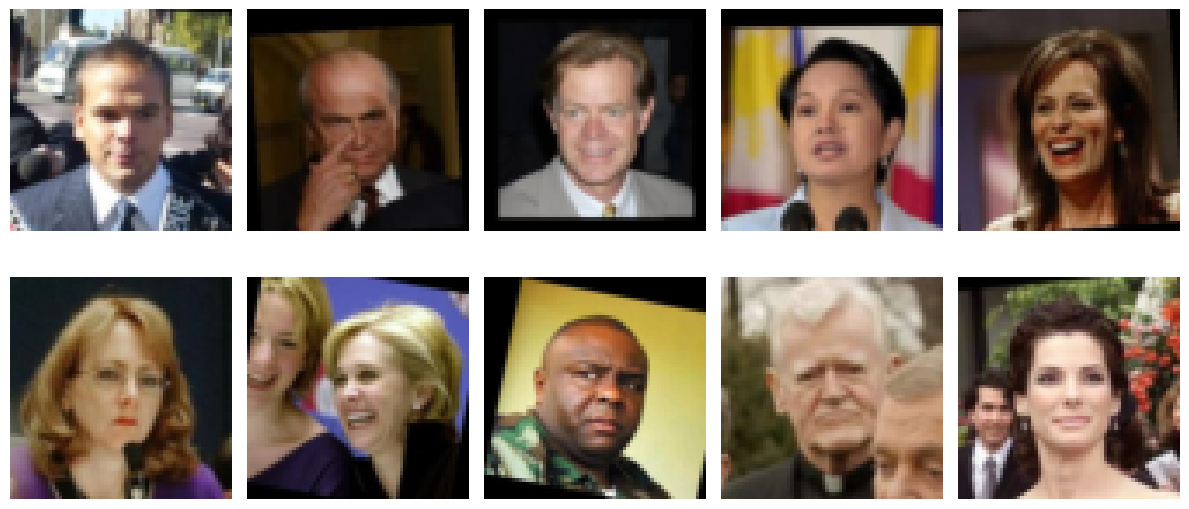

In [4]:
# -------------------------------
# Step 3: Visualize the Dataset
# -------------------------------

# Function to plot 10 images from the dataset in a 2x5 grid
def plot_images(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()
    for img, ax in zip(dataset, axes):
        img_data = img[0]  # Access image data
        img = img_data.permute(1, 2, 0)  # Rearrange dimensions for plotting
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 images from the training set
plot_images([train_dataset[i] for i in range(10)])


In [30]:
# -------------------------------
# Step 4: Build the Simplest PyTorch Model
# -------------------------------

# Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 5749)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)  # Flatten the feature maps
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x

# Instantiate the model
model = CNN()


In [31]:
# -------------------------------
# Step 5: Train the Model
# -------------------------------

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        # Print epoch results
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Train the model for 10 epochs
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch [1/10], Training Loss: 8.2052, Validation Loss: 8.1599
Epoch [2/10], Training Loss: 7.6357, Validation Loss: 8.2269
Epoch [3/10], Training Loss: 7.2728, Validation Loss: 8.5578
Epoch [4/10], Training Loss: 6.8485, Validation Loss: 8.8186
Epoch [5/10], Training Loss: 6.3641, Validation Loss: 9.2003
Epoch [6/10], Training Loss: 5.7632, Validation Loss: 9.8804
Epoch [7/10], Training Loss: 5.0043, Validation Loss: 11.2589
Epoch [8/10], Training Loss: 4.1179, Validation Loss: 13.3301
Epoch [9/10], Training Loss: 3.2415, Validation Loss: 15.6568
Epoch [10/10], Training Loss: 2.5146, Validation Loss: 16.8276


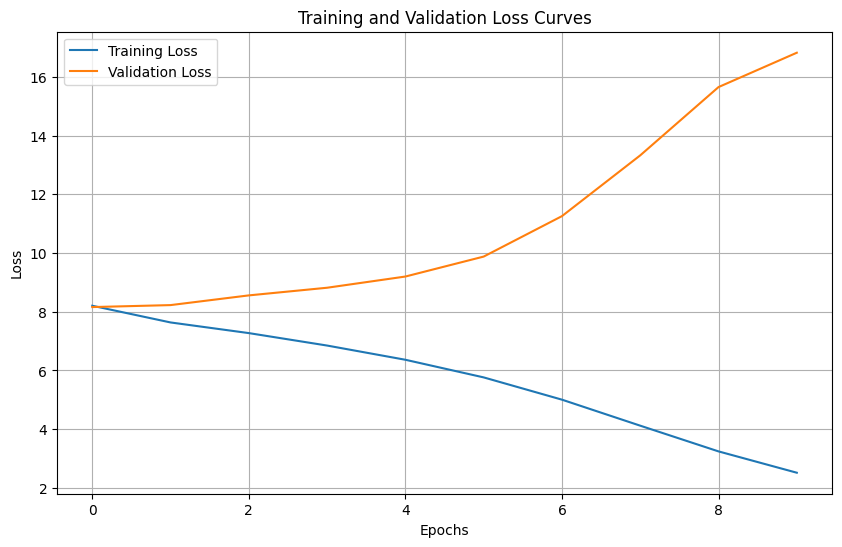

In [32]:
# -------------------------------
# Step 6: Plot Loss Curves
# -------------------------------

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# -------------------------------
# Step 7: Evaluation
# -------------------------------

# Function to calculate accuracy
def evaluate_accuracy(model, val_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()  # Evaluation mode
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

# Evaluate model accuracy on the validation set
evaluate_accuracy(model, val_loader)


Validation Accuracy: 8.58%


# Suggestions for improving the model:
* 1. **Increase Model Depth**: Add more convolutional layers and neurons in fully connected layers.
*  2. **Data Augmentation**: Apply transformations like rotations, flips, and random crops to increase the variety of training data.
* 3. **Tuning Hyperparameters**: Experiment with different learning rates, optimizers (SGD, Adam), and batch sizes.
* 4. **Regularization**: Implement techniques like dropout and weight decay to prevent overfitting.
* 5. **Use Pretrained Models**: Utilize transfer learning with models like ResNet, VGG, or MobileNet to enhance performance.
* 6. **Early Stopping and Learning Rate Scheduling**: Implement early stopping or adjust learning rate during training for better optimization.
* 7. **Cross-Validation**: Use k-fold cross-validation to ensure that the model generalizes well across different splits of data.